In [0]:
#import statements
from IPython.display import Image, display, HTML
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

! pip install unidecode
! pip install gdown
! mkdir trained_models
!mkdir helper
!mkdir imgs
import gdown
# url = 'https://drive.google.com/uc?export=download&id=1QFemk0hz7ZXj4TbQMBCEUzW5PXebCryJ'
url = 'https://drive.google.com/uc?export=download&id=1xTzseH_MCrxzTkGoxB9YgvcnUtpLROpr'
output = 'trained_models/modelb_checkpoint.pt'
gdown.download(url, output, quiet=False)

     |████████████████████████████████| 245kB 2.8MB/s 


Downloading...
From: https://drive.google.com/uc?export=download&id=1xTzseH_MCrxzTkGoxB9YgvcnUtpLROpr
To: /content/trained_models/modelb_checkpoint.pt
297MB [00:04, 65.5MB/s]


'trained_models/modelb_checkpoint.pt'

In [0]:
! mkdir output_dir
glow_file = 'helper/glow.py'
glow_url = 'https://drive.google.com/uc?export=download&id=13SzQ9XkriORBMlUlCZ3JGbm7rwG5CRmB'
gdown.download(glow_url,glow_file,quiet=False)

celeba_file = 'helper/celeba.py'
celeba_url = 'https://drive.google.com/uc?export=download&id=1SjC2DKob0inUXHqyT5bd0lWMH-Akxm2p'
gdown.download(celeba_url,celeba_file,quiet=False)

# output_dir = 'output_dir/zs.pt'
# output_url = 'https://drive.google.com/uc?export=download&id=1WnOoSxyorzywVNtNPonb1TY0Ml3IhwWJ'
# gdown.download(output_url,output_dir,quiet=False)

output_dir = 'output_dir/z_manipulate.pt'
output_url = 'https://drive.google.com/uc?export=download&id=19wXodJ_z228rMtzyrawHt41H_gbJXlM8'
gdown.download(output_url,output_dir,quiet=False)

# output_dir = 'output_dir/attrs.pt'
# output_url = 'https://drive.google.com/uc?export=download&id=1BDhpUeQwwQ9SV65qtcQyj0OjxF8u6w1X'
# gdown.download(output_url,output_dir,quiet=False)

img_dir = 'imgs/000174.jpg'
img_url = 'https://drive.google.com/uc?export=download&id=1HouTgDb0n72AIk7qJwESwRNcYZtPCsnm'
gdown.download(img_url,img_dir,quiet=False)

img_dir = 'imgs/000214.jpg'
img_url = 'https://drive.google.com/uc?export=download&id='
gdown.download(img_url,img_dir,quiet=False)

img_dir = 'imgs/000382.jpg'
img_url = 'https://drive.google.com/uc?export=download&id='
gdown.download(img_url,img_dir,quiet=False)

img_dir = 'imgs/002844.jpg'
img_url = 'https://drive.google.com/uc?export=download&id='
gdown.download(img_url,img_dir,quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=13SzQ9XkriORBMlUlCZ3JGbm7rwG5CRmB
To: /content/helper/glow.py
100%|██████████| 15.4k/15.4k [00:00<00:00, 3.31MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1SjC2DKob0inUXHqyT5bd0lWMH-Akxm2p
To: /content/helper/celeba.py
100%|██████████| 5.64k/5.64k [00:00<00:00, 2.00MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=19wXodJ_z228rMtzyrawHt41H_gbJXlM8
To: /content/output_dir/z_manipulate.pt
100%|██████████| 1.97M/1.97M [00:00<00:00, 156MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1HouTgDb0n72AIk7qJwESwRNcYZtPCsnm
To: /content/imgs/000174.jpg
100%|██████████| 7.05k/7.05k [00:00<00:00, 2.71MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=
To: /content/imgs/000214.jpg
145B [00:00, 62.6kB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=
To: /content/imgs/000382.jpg
145B [00:00, 56.1kB/s]
Downloading.

'imgs/002844.jpg'

In [0]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision.transforms as T
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.utils.checkpoint import checkpoint
from PIL import Image
import sys
sys.path.append('/content/helper/')
from torchvision.datasets import MNIST
from celeba import CelebA
from glow import Glow

In [0]:
def encode_dataset(model, dataloader):
    model.eval()

    zs = []
    attrs = []
    for i, (x,y) in enumerate(dataloader):
        print('Encoding [{}/{}]'.format(i+1, len(dataloader)), end='\r')
        x = x.to(args['device'])
        zs_i, _ = model(x)
        zs.append(torch.cat([z.flatten(1) for z in zs_i], dim=1))
        attrs.append(y)

    zs = torch.cat(zs, dim=0)
    attrs = torch.cat(attrs, dim=0)
    print('Encoding completed.')
    return zs, attrs

def compute_dz(zs, attrs, idx):
    """ for a given attribute idx, compute the mean for all encoded z's corresponding to the positive and negative attribute """
    z_pos = [zs[i] for i in range(len(zs)) if attrs[i][idx] == +1]
    z_neg = [zs[i] for i in range(len(zs)) if attrs[i][idx] == -1]
    # dz = z_pos - z_neg; where z_pos is mean of all encoded datapoints where attr is present;
    return torch.stack(z_pos).mean(0) - torch.stack(z_neg).mean(0)   # out tensor of shape (flattened zs dim,)

def get_manipulators(zs, attrs):
    """ compute dz (= z_pos - z_neg) for each attribute """
    print('Extracting manipulators...', end=' ')
    dzs = 1.6 * torch.stack([compute_dz(zs, attrs, i) for i in range(attrs.shape[1])], dim=0)  # compute dz for each attribute official code multiplies by 1.6 scalar here
    print('Completed.')
    return dzs  # out (n_attributes, flattened zs dim)
    
def manipulate(model, z, dz, z_std, alpha):
    # 1. record incoming shapes
    z_dims   = [z_.squeeze().shape   for z_ in z]
    z_numels = [z_.numel() for z_ in z]
    # 2. flatten z into a vector and manipulate by alpha in the direction of dz
    z = torch.cat([z_.flatten(1) for z_ in z], dim=1).to(dz.device)
    # print(dz,z)
    z = z + dz * torch.tensor(alpha).float().view(-1,1).to(dz.device)  # out (n_alphas, flattened zs dim)
    # 3. reshape back to z shapes from each level of the model
    zs = [z_.view((len(alpha), *dim)) for z_, dim in zip(z.split(z_numels, dim=1), z_dims)]
    # 4. decode
    return model.inverse(zs, z_std=z_std)[0]

def load_manipulators(model, args):
    # construct dataloader with limited number of images
    args['mini_data_size'] = 30000
    # load z manipulators for each attribute
    if os.path.exists(os.path.join(args['output_dir'], 'z_manipulate.pt')):
        z_manipulate = torch.load(os.path.join(args['output_dir'], 'z_manipulate.pt'), map_location=args['device'])
    else:
        # encode dataset, compute manipulators, store zs, attributes, and dzs
        dataloader = fetch_dataloader(args, train=True)
        zs, attrs = encode_dataset(model, dataloader)
        z_manipulate = get_manipulators(zs, attrs)
        torch.save(zs, os.path.join(args['output_dir'], 'zs.pt'))
        torch.save(attrs, os.path.join(args['output_dir'], 'attrs.pt'))
        torch.save(z_manipulate, os.path.join(args['output_dir'], 'z_manipulate.pt'))
    return z_manipulate

@torch.no_grad()
def visualize(model, args,attrs=None, alphas=None, img_path=None, n_examples=1):
    """ manipulate an input image along a given attribute """
    # dataset = fetch_dataloader(args, train=False).dataset  # pull the dataset to access transforms and attrs
    # if no attrs passed, manipulate all of them
    z_std=0.6
    if not attrs:
        attrs = list(range(len(dataset.attr_names)))
        # print('Attrs',attrs.item())
    # if image is passed, manipulate only the image
    if img_path is not None:
        img = img_path
        x = img
        # img = Image.open(img_path)
        # print('Img size',img.size)
        # x = dataset.transform(img)  # transform image to tensor and encode
    else:  # take first n_examples from the dataset
        x, _ = dataset[0]
    z, _ = model(x.unsqueeze(0).to(args['device']))
    # get manipulors
    z_manipulate = load_manipulators(model,args)
    # decode the varied attributes
    dec_x =[]
    for attr_idx in attrs:
        dec_x.append(manipulate(model, z, z_manipulate[attr_idx].unsqueeze(0), z_std, alphas))
    return torch.stack(dec_x).cpu()


In [0]:
args = {}
args['input_dims'] = (3,64,64)
args['dataset'] = 'celeba'
args['distributed']= False
args['train'] = False
args['batch_size_init'] = 256
args['batch_size'] = 40
args['device'] = torch.device('cuda')
args['width'] = 512
args['depth'] = 32
args['n_levels'] = 3
args['data_dir'] = '/content/drive/My Drive/PGM Project/datasets/data/'
args['output_dir'] = '/content/output_dir/'
args['mini_data_size'] = None
args['n_bits'] = 5
args['vis_alphas'] = [-3,-2,-1,0,1,2,3]
# os.makedirs(args['output_dir'],exist_ok=True)
model = Glow(args['width'], args['depth'], args['n_levels'],args['input_dims'],False).to(args['device'])
model = torch.nn.parallel.DataParallel(model)
model.base_dist = model.module.base_dist
model.log_prob = model.module.log_prob
model.inverse = model.module.inverse

model_checkpoint = torch.load(output, map_location=args['device'])
model.load_state_dict(model_checkpoint['state_dict'])


<All keys matched successfully>

In [0]:
def show_images(im1, im2):
    plt.figure(figsize=(5,5))
    columns = 2
    im1,im2 = pil_transform(im1),pil_transform(im2)
    images = [im1,im2]
    # images = [mpimg.imread(im1), mpimg.imread(im2)]

    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

In [0]:
import glob
my_imgs = glob.glob('/content/imgs/*.jpg')
print(my_imgs)
filename = my_imgs[2]
attrs = [28,39,23,9,24]
flag=0
base_params = [0,0,0,0,0]

['/content/imgs/002844.jpg', '/content/imgs/000382.jpg', '/content/imgs/000174.jpg', '/content/imgs/000214.jpg']


In [0]:
def parse_results(cur_img,changed_param_idx,new_value):
    dec_x = visualize(model,args,attrs=[attrs[changed_param_idx]],alphas=args['vis_alphas'] ,img_path = cur_img)
    print(dec_x.shape)
    param_idx_map = {-2:0,-1:1,0:2,1:3,2:4}
    param_idx = param_idx_map[new_value]
    im2 = dec_x[0,param_idx,:,:,:]
    im2 = im2.view(*args['input_dims'])
    # im2 = pil_transform(im2)
    return im2

In [0]:
base_params = [0,0,0,0,0]
cur_params = base_params

trnsfm = T.Compose([
                    T.Resize((64,64)),
                    T.Lambda(lambda im: np.array(im, dtype=np.float32)),                     # to numpy
                    T.Lambda(lambda x: np.floor(x / 2**(8 - args['n_bits'])) / 2**args['n_bits']), # lower bits
                    T.ToTensor(),  # note: if input to this transform is uint8, it divides by 255 and returns float
                    T.Lambda(lambda t: t + torch.rand_like(t) / 2**args['n_bits']
                )])   
# dataset = fetch_dataloader(args, train=False).dataset 
# print(dataset)
changed_param_idx = 0
new_value = 0

pil_transform = T.ToPILImage()

im1 = Image.open(filename)
im1 = trnsfm(im1)
# im1 = pil_transform(im1)
base_img = im1
print(base_img.size)
cur_img = base_img

<built-in method size of Tensor object at 0x7f1e24dbd558>


torch.Size([1, 7, 3, 64, 64])
3


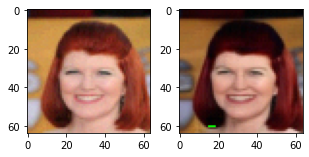

[0, 0, 0, 0, 0]
[0, 0, -2, 0, 0]
torch.Size([1, 7, 3, 64, 64])
2


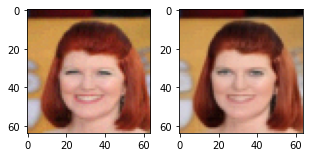

In [0]:
#@title Inputs { display-mode: "form", run: "auto"}
Hairline = 0 #@param {type:"slider", min:-2, max:2, step:1}
__Age___ = 0 #@param {type:"slider", min:-2, max:2, step:1}
__Eyes__ = 0 #@param {type:"slider", min:-2, max:2, step:1}
_Blonde_ = 0 #@param {type:"slider", min:-2, max:2, step:1}
_Beard__ = 0 #@param {type:"slider", min:-2, max:2, step:1}

params = [Hairline, __Age___, __Eyes__, _Blonde_ , _Beard__]
print(params)
print(cur_params)
changed_param_idx = int(np.nonzero(np.array(cur_params)-np.array(params))[0])
new_value = params[changed_param_idx]

im2 = parse_results(cur_img,changed_param_idx,new_value)
show_images(base_img,im2)
print(changed_param_idx)
cur_params = params
# Image(filename)

# show_images(filename,filename)
#insert code here to generate image using params
# to show original image and updated image, run "show_images(filename, <updated file name>)"